# Setting

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!wget --no-check-certificate https://apps.peer.berkeley.edu/phichallenge/dataset/task5_collapse_mode.zip
!unzip task5_collapse_mode.zip

--2020-10-26 23:06:07--  https://apps.peer.berkeley.edu/phichallenge/dataset/task5_collapse_mode.zip
Resolving apps.peer.berkeley.edu (apps.peer.berkeley.edu)... 128.32.143.24, 2607:f140:0:f::24
Connecting to apps.peer.berkeley.edu (apps.peer.berkeley.edu)|128.32.143.24|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 232967101 (222M) [application/zip]
Saving to: ‘task5_collapse_mode.zip’

task5_collapse_mode 100%[===================>] 222.17M  39.5MB/s    in 6.0s    

2020-10-26 23:06:14 (36.7 MB/s) - ‘task5_collapse_mode.zip’ saved [232967101/232967101]

Archive:  task5_collapse_mode.zip
   creating: task5/
  inflating: task5/task5_X_test.npy  
  inflating: task5/task5_y_test.npy  
  inflating: task5/task5_X_train.npy  
  inflating: task5/task5_y_train.npy  
  inflating: task5/license.txt       
  inflating: task5/README.txt        


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.layers.convolutional import Conv2D
from keras.layers import Flatten,BatchNormalization
from keras.layers.merge import add
from keras.models import Sequential
from keras.layers import Input, merge, ZeroPadding2D
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.models import Model
tf.__version__

'2.3.0'

# Data Preprocessing

In [7]:
# base_file_path = 'tData/Chunks/'
# train_x_path = 'X_train_1.npy'
# test_x_path = 'X_test_1.npy'
# train_y_path = 'Y_train_1.npy'
# test_y_path = 'Y_test_1.npy'
base_file_path = 'task5/'
train_x_path = 'task5_X_train.npy'
test_x_path = 'task5_X_test.npy'
train_y_path = 'task5_y_train.npy'
test_y_path = 'task5_y_test.npy'


In [8]:
file_path = base_file_path + train_x_path
train_x_w = np.load(file_path)
np.random.seed(1)
np.random.shuffle(train_x_w)

In [9]:
file_path = base_file_path + train_y_path
train_y_w = np.load(file_path)
np.random.seed(1)
np.random.shuffle(train_y_w)

[[[ 50.060997   -15.778999   -35.68      ]
  [ 49.060997   -16.779      -36.68      ]
  [ 49.060997   -16.779      -36.68      ]
  ...
  [ 48.060997   -18.779      -36.68      ]
  [ 48.060997   -18.779      -36.68      ]
  [ 48.060997   -18.779      -36.68      ]]

 [[ 47.060997   -18.779      -38.68      ]
  [ 47.060997   -18.779      -38.68      ]
  [ 47.060997   -18.779      -38.68      ]
  ...
  [ 48.060997   -18.779      -36.68      ]
  [ 48.060997   -18.779      -36.68      ]
  [ 48.060997   -18.779      -36.68      ]]

 [[ 45.060997   -20.779      -40.68      ]
  [ 45.060997   -20.779      -40.68      ]
  [ 45.060997   -20.779      -40.68      ]
  ...
  [ 48.060997   -18.779      -36.68      ]
  [ 48.060997   -18.779      -36.68      ]
  [ 48.060997   -18.779      -36.68      ]]

 ...

 [[ -3.939003   -10.778999    19.32      ]
  [ -4.939003   -11.778999    18.32      ]
  [ -7.939003   -12.778999    17.32      ]
  ...
  [-11.939003   -14.778999     2.3199997 ]
  [-14.939003   -1

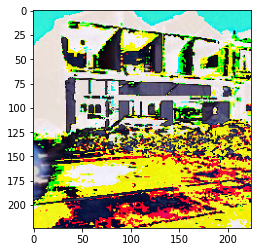

In [10]:
index = 601 
train_x_w[index] += 80
print(train_x_w[index])
plt.imshow(train_x_w[index].astype('uint8'))
print ("y = " + str(train_y_w[index]))
train_x_w[index] -= 80

In [11]:
n = len(train_x_w)
train_x = train_x_w[0:int(n*0.8)]
val_x = train_x_w[int(n*0.8):]
train_y = train_y_w[0:int(n*0.8)]
val_y = train_y_w[int(n*0.8):]

In [15]:
file_path = base_file_path + train_y_path
test_X = np.load(file_path)


In [16]:
file_path = base_file_path + test_y_path
test_y = np.load(file_path)


# Data Augmentation

In [17]:
from keras.preprocessing.image import *

In [28]:
# Not 100% sure how this works but I think a data generator is the way to go
base_generator = ImageDataGenerator(
    data_format = 'channels_last'
)
  
data_augmentation_generator = ImageDataGenerator(
  data_format = 'channels_last',
  horizontal_flip = True, 
  rotation_range = 30, 
  validation_split = None
)

# Model

In [19]:
def compile_and_fit(model, generator, patience=2, MAX_EPOCHS = 30, early_stop = False, val_split = 0.1, decay_step = 500,
                    batch_size = 64, initial_lr = 1e-3, lr_decay_rate = 0.9):

    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate= initial_lr,
        decay_steps= decay_step,
        decay_rate= lr_decay_rate)
  
    model.compile(loss=tf.losses.categorical_crossentropy,
                optimizer=tf.optimizers.Adam(learning_rate= lr_schedule),
                metrics=['accuracy'])

  
    if (early_stop == False):
    # history = model.fit(train_x, train_y, epochs=MAX_EPOCHS, batch_size = batch_size, validation_data = (val_x, val_y))
        history = model.fit(generator.flow(train_x, train_y, batch_size = batch_size), epochs = MAX_EPOCHS )
    else:
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=patience,
                                                        mode='min')
        history = model.fit(train_x, train_y, epochs=MAX_EPOCHS, batch_size = batch_size, validation_split = val_split, callbacks=[early_stopping])

    return history

## Baseline

In [20]:
input_shape = train_x_w.shape[1:]
num_class = train_y_w.shape[1]

In [21]:
layers=[
    tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding="same",activation=tf.nn.relu,input_shape=input_shape),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    
    tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
        
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128,activation=tf.nn.relu),
    
    tf.keras.layers.Dense(units=num_class, activation=tf.nn.softmax)
]

baseline=tf.keras.Sequential(layers)
baseline.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               25690240  
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3

In [22]:
history = compile_and_fit(data_augmentation_generator, baseline)

train_performance = {}
val_performance = {}
performance = {}
train_performance['Baseline'] = baseline.evaluate(train_X, train_y, verbose= 1)
performance['Baseline'] = baseline.evaluate(test_X, test_y, verbose= 1)
train_performance['Baseline']

Epoch 1/30
16/16 [==============================] - 8s 527ms/step - loss: 964.5554 - accuracy: 0.3398
Epoch 2/30
16/16 [==============================] - 9s 562ms/step - loss: 4.5707 - accuracy: 0.2918
Epoch 3/30
16/16 [==============================] - 9s 562ms/step - loss: 1.0943 - accuracy: 0.3561
Epoch 4/30
16/16 [==============================] - 9s 561ms/step - loss: 1.0818 - accuracy: 0.3980
Epoch 5/30
16/16 [==============================] - 9s 562ms/step - loss: 1.0738 - accuracy: 0.4276
Epoch 6/30
16/16 [==============================] - 9s 565ms/step - loss: 1.0606 - accuracy: 0.4398
Epoch 7/30
16/16 [==============================] - 9s 568ms/step - loss: 1.0469 - accuracy: 0.4388
Epoch 8/30
16/16 [==============================] - 9s 575ms/step - loss: 1.0454 - accuracy: 0.4439
Epoch 9/30
16/16 [==============================] - 9s 582ms/step - loss: 1.0246 - accuracy: 0.4612
Epoch 10/30
16/16 [==============================] - 9s 569ms/step - loss: 1.0247 - accuracy: 0.45

31/31 [==============================] - 1s 17ms/step - loss: 0.8033 - accuracy: 0.6398


## AlexNet

In [36]:
# Ref: https://github.com/Keyird/DeepLearning-TensorFlow2/blob/master/4.%20AlexNet/AlexNet.py
Alex_layers=[
    # layer 1
    tf.keras.layers.Conv2D(48, kernel_size=11, strides=4, padding='same', activation='relu', input_shape=input_shape), 
    tf.keras.layers.MaxPooling2D(pool_size=3, strides=2),  
    # layer 2
    tf.keras.layers.Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu'),  
    tf.keras.layers.MaxPooling2D(pool_size=3, strides=2),  
    # layer 3
    tf.keras.layers.Conv2D(192, kernel_size=3, strides=1, padding='same', activation='relu'), 
    # layer 4
    tf.keras.layers.Conv2D(192, kernel_size=3, strides=1, padding='same', activation='relu'),
    # layer 5
    tf.keras.layers.Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=3, strides=2),
    tf.keras.layers.Flatten(), 
    # layer 6
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    # layer 7
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    # layer 8
    tf.keras.layers.Dense(num_class)
]

AlexNet=tf.keras.Sequential(Alex_layers)
AlexNet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 56, 56, 48)        17472     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 27, 27, 48)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 27, 128)       153728    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 192)       221376    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 192)       331968    
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 13, 128)      

In [ ]:
history = compile_and_fit(AlexNet)

train_performance['AlexNet'] = AlexNet.evaluate(train_x, train_y, verbose= 1)
val_performance['AlexNet'] = AlexNet.evaluate(val_x, val_y, verbose= 1)
performance['AlexNet'] = AlexNet.evaluate(test_X, test_y, verbose= 1)

Epoch 1/30
16/16 [==============================] - 1s 50ms/step - loss: 1.0288 - accuracy: 0.1418 - val_loss: 1.1287 - val_accuracy: 0.1545
Epoch 2/30
16/16 [==============================] - 1s 42ms/step - loss: 1.2704 - accuracy: 0.1551 - val_loss: 1.5352 - val_accuracy: 0.1626
Epoch 3/30
16/16 [==============================] - 1s 42ms/step - loss: 0.9998 - accuracy: 0.1398 - val_loss: 1.1170 - val_accuracy: 0.1748
Epoch 4/30
16/16 [==============================] - 1s 42ms/step - loss: 1.0172 - accuracy: 0.1561 - val_loss: 1.0274 - val_accuracy: 0.1992
Epoch 5/30
16/16 [==============================] - 1s 43ms/step - loss: 1.0775 - accuracy: 0.1490 - val_loss: 1.5887 - val_accuracy: 0.1789
Epoch 6/30
16/16 [==============================] - 1s 42ms/step - loss: 1.7334 - accuracy: 0.2041 - val_loss: 1.1982 - val_accuracy: 0.2114
Epoch 7/30
16/16 [==============================] - 1s 43ms/step - loss: 1.1290 - accuracy: 0.2153 - val_loss: 1.0442 - val_accuracy: 0.2114
Epoch 8/30
16

## VGG

### VGG11

In [ ]:
# Ref: https://github.com/Keyird/DeepLearning-TensorFlow2/blob/master/5.%20VGG11/VGG11.py
VGG11_layers=[
    # layer 1
    tf.keras.layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu', input_shape = input_shape),
    tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
    # layer 2
    tf.keras.layers.Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
    # layer 3
    tf.keras.layers.Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu'),
    # layer 4
    tf.keras.layers.Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
    # layer 5
    tf.keras.layers.Conv2D(512, kernel_size=3, strides=1, padding='same', activation='relu'),
    # layer 6
    tf.keras.layers.Conv2D(512, kernel_size=3, strides=1, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
    # layer 7
    tf.keras.layers.Conv2D(512, kernel_size=3, strides=1, padding='same', activation='relu'),
    # layer 8
    tf.keras.layers.Conv2D(512, kernel_size=3, strides=1, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
    tf.keras.layers.Flatten(), 
    # layer 9
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    # layer 10
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    # layer 11
    tf.keras.layers.Dense(num_class, activation='softmax')
]

VGG11=tf.keras.Sequential(VGG11_layers)
VGG11.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 56, 56, 256)       295168    
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 56, 56, 256)       590080    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 28, 28, 256)      

In [ ]:
history = compile_and_fit(VGG11)

train_performance['VGG11'] = VGG11.evaluate(train_x, train_y, verbose= 1)
val_performance['VGG11'] = VGG11.evaluate(val_x, val_y, verbose= 1)
performance['VGG11'] = VGG11.evaluate(test_X, test_y, verbose= 1)

Epoch 1/30
16/16 [==============================] - 6s 397ms/step - loss: 0.1085 - accuracy: 0.9633 - val_loss: 1.1917 - val_accuracy: 0.8008
Epoch 2/30
16/16 [==============================] - 6s 385ms/step - loss: 0.0399 - accuracy: 0.9847 - val_loss: 1.2009 - val_accuracy: 0.7683
Epoch 3/30
16/16 [==============================] - 6s 384ms/step - loss: 0.0336 - accuracy: 0.9888 - val_loss: 1.3640 - val_accuracy: 0.7724
Epoch 4/30
16/16 [==============================] - 6s 385ms/step - loss: 0.0778 - accuracy: 0.9816 - val_loss: 1.5804 - val_accuracy: 0.7195
Epoch 5/30
16/16 [==============================] - 6s 385ms/step - loss: 0.0628 - accuracy: 0.9827 - val_loss: 1.4561 - val_accuracy: 0.7154
Epoch 6/30
16/16 [==============================] - 6s 385ms/step - loss: 0.1000 - accuracy: 0.9755 - val_loss: 1.3159 - val_accuracy: 0.7317
Epoch 7/30
16/16 [==============================] - 6s 385ms/step - loss: 0.0446 - accuracy: 0.9867 - val_loss: 1.2564 - val_accuracy: 0.7358
Epoch 

### VGG16

In [ ]:
# Ref: https://keras.io/api/applications/vgg/
VGG16 = tf.keras.applications.VGG16(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=input_shape,
    pooling= max,
    classes= num_class,
    classifier_activation="softmax",
)

VGG16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
history = compile_and_fit(VGG16)

train_performance['VGG16'] = VGG16.evaluate(train_x, train_y, verbose= 1)
val_performance['VGG16'] = VGG16.evaluate(val_x, val_y, verbose= 1)
performance['VGG16'] = VGG16.evaluate(test_X, test_y, verbose= 1)

Epoch 1/30
16/16 [==============================] - 14s 898ms/step - loss: 1080.9412 - accuracy: 0.3653 - val_loss: 1.1003 - val_accuracy: 0.3293
Epoch 2/30
16/16 [==============================] - 13s 806ms/step - loss: 1.1446 - accuracy: 0.4000 - val_loss: 1.0875 - val_accuracy: 0.4187
Epoch 3/30
16/16 [==============================] - 13s 819ms/step - loss: 1.0858 - accuracy: 0.4306 - val_loss: 1.0825 - val_accuracy: 0.4146
Epoch 4/30
16/16 [==============================] - 13s 827ms/step - loss: 1.0786 - accuracy: 0.4316 - val_loss: 1.0825 - val_accuracy: 0.4146
Epoch 5/30
16/16 [==============================] - 13s 816ms/step - loss: 1.0757 - accuracy: 0.4316 - val_loss: 1.0907 - val_accuracy: 0.4146
Epoch 6/30
16/16 [==============================] - 13s 805ms/step - loss: 1.0777 - accuracy: 0.4316 - val_loss: 1.0808 - val_accuracy: 0.4146
Epoch 7/30
16/16 [==============================] - 13s 805ms/step - loss: 1.0847 - accuracy: 0.4316 - val_loss: 1.0815 - val_accuracy: 0.4

### VGG19

In [ ]:
# Ref: https://keras.io/api/applications/vgg/
VGG19 = tf.keras.applications.VGG19(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=input_shape,
    pooling= max,
    classes= num_class,
    classifier_activation="softmax",
)

VGG19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
history = compile_and_fit(VGG19)

train_performance['VGG19'] = VGG19.evaluate(train_x, train_y, verbose= 1)
val_performance['VGG19'] = VGG19.evaluate(val_x, val_y, verbose= 1)
performance['VGG19'] = VGG19.evaluate(test_X, test_y, verbose= 1)

Epoch 1/30
16/16 [==============================] - 16s 984ms/step - loss: 7163.2656 - accuracy: 0.3602 - val_loss: 1.1120 - val_accuracy: 0.3252
Epoch 2/30
16/16 [==============================] - 15s 950ms/step - loss: 1.1383 - accuracy: 0.3908 - val_loss: 1.0788 - val_accuracy: 0.3496
Epoch 3/30
16/16 [==============================] - 15s 952ms/step - loss: 1.0814 - accuracy: 0.4255 - val_loss: 1.0767 - val_accuracy: 0.4146
Epoch 4/30
16/16 [==============================] - 16s 977ms/step - loss: 1.0884 - accuracy: 0.4316 - val_loss: 1.0889 - val_accuracy: 0.4146
Epoch 5/30
16/16 [==============================] - 15s 950ms/step - loss: 1.0898 - accuracy: 0.4316 - val_loss: 1.0864 - val_accuracy: 0.4146
Epoch 6/30
16/16 [==============================] - 15s 947ms/step - loss: 1.0820 - accuracy: 0.4316 - val_loss: 1.0816 - val_accuracy: 0.4146
Epoch 7/30
16/16 [==============================] - 15s 951ms/step - loss: 1.0770 - accuracy: 0.4316 - val_loss: 1.0936 - val_accuracy: 0.4

## GoogleNet

In [ ]:
# Ref: https://github.com/guaiguaibao/GoogLeNet_Tensorflow2.0/blob/master/tensorflow2.0/GoogLeNet/model.py
def GoogLeNet(im_height=224, im_width=224, class_num=num_class, aux_logits=False):
    input_image = layers.Input(shape= input_shape, dtype="float32")
    # (None, 224, 224, 3)
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding="SAME", activation="relu", name="conv2d_1")(input_image)
    # (None, 112, 112, 64)
    x = layers.MaxPool2D(pool_size=3, strides=2, padding="SAME", name="maxpool_1")(x)
    # (None, 56, 56, 64)
    x = layers.Conv2D(64, kernel_size=1, activation="relu", name="conv2d_2")(x)
    # (None, 56, 56, 64)
    x = layers.Conv2D(192, kernel_size=3, padding="SAME", activation="relu", name="conv2d_3")(x)
    # (None, 56, 56, 192)
    x = layers.MaxPool2D(pool_size=3, strides=2, padding="SAME", name="maxpool_2")(x)

    # (None, 28, 28, 192)
    x = Inception(64, 96, 128, 16, 32, 32, name="inception_3a")(x)
    # (None, 28, 28, 256)
    x = Inception(128, 128, 192, 32, 96, 64, name="inception_3b")(x)

    # (None, 28, 28, 480)
    x = layers.MaxPool2D(pool_size=3, strides=2, padding="SAME", name="maxpool_3")(x)
    # (None, 14, 14, 480)
    x = Inception(192, 96, 208, 16, 48, 64, name="inception_4a")(x)
    if aux_logits:
        aux1 = InceptionAux(class_num, name="aux_1")(x)

    # (None, 14, 14, 512)
    x = Inception(160, 112, 224, 24, 64, 64, name="inception_4b")(x)
    # (None, 14, 14, 512)
    x = Inception(128, 128, 256, 24, 64, 64, name="inception_4c")(x)
    # (None, 14, 14, 512)
    x = Inception(112, 144, 288, 32, 64, 64, name="inception_4d")(x)
    if aux_logits:
        aux2 = InceptionAux(class_num, name="aux_2")(x)

    # (None, 14, 14, 528)
    x = Inception(256, 160, 320, 32, 128, 128, name="inception_4e")(x)
    # (None, 14, 14, 532)
    x = layers.MaxPool2D(pool_size=3, strides=2, padding="SAME", name="maxpool_4")(x)

    # (None, 7, 7, 832)
    x = Inception(256, 160, 320, 32, 128, 128, name="inception_5a")(x)
    # (None, 7, 7, 832)
    x = Inception(384, 192, 384, 48, 128, 128, name="inception_5b")(x)
    # (None, 7, 7, 1024)
    x = layers.AvgPool2D(pool_size=7, strides=1, name="avgpool_1")(x)

    # (None, 1, 1, 1024)
    x = layers.Flatten(name="output_flatten")(x)
    # (None, 1024)
    x = layers.Dropout(rate=0.4, name="output_dropout")(x)
    x = layers.Dense(class_num, name="output_dense")(x)
    # (None, class_num)
    aux3 = layers.Softmax(name="aux_3")(x)

    if aux_logits:
        model = models.Model(inputs=input_image, outputs=[aux1, aux2, aux3])
    else:
        model = models.Model(inputs=input_image, outputs=aux3)
    return model


# Inception
class Inception(layers.Layer):
    def __init__(self, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj, **kwargs):
       
        super(Inception, self).__init__(**kwargs)
        self.branch1 = layers.Conv2D(ch1x1, kernel_size=1, activation="relu")

        self.branch2 = Sequential([
            layers.Conv2D(ch3x3red, kernel_size=1, activation="relu"),
            layers.Conv2D(ch3x3, kernel_size=3, padding="SAME", activation="relu")])      # output_size= input_size

        self.branch3 = Sequential([
            layers.Conv2D(ch5x5red, kernel_size=1, activation="relu"),
            layers.Conv2D(ch5x5, kernel_size=5, padding="SAME", activation="relu")])      # output_size= input_size

        self.branch4 = Sequential([
            layers.MaxPool2D(pool_size=3, strides=1, padding="SAME"),  # caution: default strides==pool_size
            layers.Conv2D(pool_proj, kernel_size=1, activation="relu")])                  # output_size= input_size

    def call(self, inputs, **kwargs):
        branch1 = self.branch1(inputs)
        branch2 = self.branch2(inputs)
        branch3 = self.branch3(inputs)
        branch4 = self.branch4(inputs)
        outputs = layers.concatenate([branch1, branch2, branch3, branch4])
        return outputs


class InceptionAux(layers.Layer):
    def __init__(self, num_classes, **kwargs):
        super(InceptionAux, self).__init__(**kwargs)
        self.averagePool = layers.AvgPool2D(pool_size=5, strides=3)
        self.conv = layers.Conv2D(128, kernel_size=1, activation="relu")

        self.fc1 = layers.Dense(1024, activation="relu")
        self.fc2 = layers.Dense(num_classes)
        self.softmax = layers.Softmax()

    def call(self, inputs, **kwargs):
        # aux1: N x 512 x 14 x 14, aux2: N x 528 x 14 x 14
        x = self.averagePool(inputs)
        # aux1: N x 512 x 4 x 4, aux2: N x 528 x 4 x 4
        x = self.conv(x)
        # N x 128 x 4 x 4
        x = layers.Flatten()(x)
        x = layers.Dropout(rate=0.5)(x)  
        # N x 2048
        x = self.fc1(x)
        x = layers.Dropout(rate=0.5)(x)
        # N x 1024
        x = self.fc2(x)
        # N x num_classes
        x = self.softmax(x)

        return x

GoogleNet_model = GoogLeNet(class_num = num_class)
GoogleNet_model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      9472      
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        4160      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 192)       110784    
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 28, 28, 192)       0         
_________________________________________________________________
inception_3a (Inception)     (None, 28, 28, 256)      

In [ ]:
history = compile_and_fit(GoogleNet_model)

train_performance['GoogleNet_model'] = GoogleNet_model.evaluate(train_x, train_y, verbose= 1)
val_performance['GoogleNet_model'] = GoogleNet_model.evaluate(val_x, val_y, verbose= 1)
performance['GoogleNet_model'] = GoogleNet_model.evaluate(test_X, test_y, verbose= 1)

Epoch 1/30
16/16 [==============================] - 4s 249ms/step - loss: 1.0514 - accuracy: 0.5796 - val_loss: 0.8439 - val_accuracy: 0.6382
Epoch 2/30
16/16 [==============================] - 3s 210ms/step - loss: 0.7843 - accuracy: 0.6347 - val_loss: 0.8312 - val_accuracy: 0.6260
Epoch 3/30
16/16 [==============================] - 3s 212ms/step - loss: 0.7243 - accuracy: 0.6520 - val_loss: 0.7814 - val_accuracy: 0.6545
Epoch 4/30
16/16 [==============================] - 3s 213ms/step - loss: 0.6915 - accuracy: 0.6816 - val_loss: 0.7177 - val_accuracy: 0.6667
Epoch 5/30
16/16 [==============================] - 3s 215ms/step - loss: 0.6381 - accuracy: 0.7245 - val_loss: 0.7233 - val_accuracy: 0.6748
Epoch 6/30
16/16 [==============================] - 3s 216ms/step - loss: 0.6188 - accuracy: 0.7163 - val_loss: 0.6997 - val_accuracy: 0.7033
Epoch 7/30
16/16 [==============================] - 3s 217ms/step - loss: 0.5923 - accuracy: 0.7439 - val_loss: 0.8003 - val_accuracy: 0.6748
Epoch 

## ResNet

In [ ]:
# Resnet: https://github.com/YunYang1994/TensorFlow2.0-Examples/blob/master/3-Neural_Network_Architecture/resnet.py
# Doesn't work for dimension reason
# class BasicBlock(tf.keras.Model):
#     expansion = 1

#     def __init__(self, in_channels, out_channels, strides=1):
#         super(BasicBlock, self).__init__()
#         self.conv1 = tf.keras.layers.Conv2D(out_channels, kernel_size=3, strides=strides,
#                                             padding="same", use_bias=False)
#         self.bn1 = tf.keras.layers.BatchNormalization()

#         self.conv2 = tf.keras.layers.Conv2D(out_channels, kernel_size=3, strides=1,
#                                             padding="same", use_bias=False)
#         self.bn2 = tf.keras.layers.BatchNormalization()

#         """
#         Adds a shortcut between input and residual block and merges them with "sum"
#         """
#         if strides != 1 or in_channels != self.expansion * out_channels:
#             self.shortcut = tf.keras.Sequential([
#                     tf.keras.layers.Conv2D(self.expansion*out_channels, kernel_size=1,
#                                            strides=strides, use_bias=False),
#                     tf.keras.layers.BatchNormalization()]
#                     )
#         else:
#             self.shortcut = lambda x,_: x

#     def call(self, x, training=False):
#         # if training: print("=> training network ... ")
#         out = tf.nn.relu(self.bn1(self.conv1(x), training=training))
#         out = self.bn2(self.conv2(out), training=training)
#         out += self.shortcut(x, training)
#         return tf.nn.relu(out)


# class Bottleneck(tf.keras.Model):
#     expansion = 4

#     def __init__(self, in_channels, out_channels, strides=1):
#         super(Bottleneck, self).__init__()

#         self.conv1 = tf.keras.layers.Conv2D(out_channels, 1, 1, use_bias=False)
#         self.bn1 = tf.keras.layers.BatchNormalization()
#         self.conv2 = tf.keras.layers.Conv2D(out_channels, 3, strides, padding="same", use_bias=False)
#         self.bn2 = tf.keras.layers.BatchNormalization()
#         self.conv3 = tf.keras.layers.Conv2D(out_channels*self.expansion, 1, 1, use_bias=False)
#         self.bn3 = tf.keras.layers.BatchNormalization()

#         if strides != 1 or in_channels != self.expansion * out_channels:
#             self.shortcut = tf.keras.Sequential([
#                     tf.keras.layers.Conv2D(self.expansion*out_channels, kernel_size=1,
#                                            strides=strides, use_bias=False),
#                     tf.keras.layers.BatchNormalization()]
#                     )
#         else:
#             self.shortcut = lambda x,_: x

#     def call(self, x, training=False):
#         out = tf.nn.relu(self.bn1(self.conv1(x), training))
#         out = tf.nn.relu(self.bn2(self.conv2(out), training))
#         out = self.bn3(self.conv3(out), training)
#         out += self.shortcut(x, training)
#         return tf.nn.relu(out)


# class ResNet(tf.keras.Model):
#     def __init__(self, block, num_blocks, num_classes= num_class):
#         super(ResNet, self).__init__()
#         self.in_channels = 64

#         self.conv1 = tf.keras.layers.Conv2D(64, 3, 1, padding="same", use_bias=False)
#         self.bn1 = tf.keras.layers.BatchNormalization()

#         self.layer1 = self._make_layer(block,  64, num_blocks[0], stride=1)
#         self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
#         self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
#         self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

#         self.avg_pool2d = tf.keras.layers.AveragePooling2D(4)
#         self.linear = tf.keras.layers.Dense(units=num_classes, activation="softmax")

#     def _make_layer(self, block, out_channels, num_blocks, stride):
#         strides = [stride] + [1] * (num_blocks - 1)
#         layers = []
#         for stride in strides:
#             layers.append(block(self.in_channels, out_channels, stride))
#             self.in_channels = out_channels * block.expansion
#         return tf.keras.Sequential(layers)

#     def call(self, x, training=False):
#         out = tf.nn.relu(self.bn1(self.conv1(x), training))
#         out = self.layer1(out, training=training)
#         out = self.layer2(out, training=training)
#         out = self.layer3(out, training=training)
#         out = self.layer4(out, training=training)

#         # For classification
#         out = self.avg_pool2d(out)
#         out = tf.reshape(out, (out.shape[0], -1))
#         out = self.linear(out)
#         return out

# def ResNet18():
#     return ResNet(BasicBlock, [2,2,2,2])

# def ResNet34():
#     return ResNet(BasicBlock, [3,4,6,3])

# def ResNet50():
#     return ResNet(Bottleneck, [3,4,14,3])

# def ResNet101():
#     return ResNet(Bottleneck, [3,4,23,3])

# def ResNet152():
#     return ResNet(Bottleneck, [3,8,36,3])

# ResNet_model = ResNet152()
# ResNet_model.build(input_shape= (64, train_x.shape[1], train_x.shape[2], train_x.shape[3]))
# ResNet_model.summary()

### Resnet 50

In [29]:
# Ref: https://keras.io/api/applications/resnet/
ResNet50 = tf.keras.applications.ResNet50(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=input_shape,
    pooling= max,
    classes= num_class,
    classifier_activation="softmax",
)

ResNet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [31]:
history = compile_and_fit(ResNet50, base_generator)

train_performance['ResNet50'] = ResNet50.evaluate(train_x, train_y, verbose= 1)
val_performance['ResNet50'] = ResNet50.evaluate(val_x, val_y, verbose= 1)
# performance['ResNet50'] = ResNet50.evaluate(test_X, test_y, verbose= 1)

history = compile_and_fit(ResNet50, data_augmentation_generator)

train_performance['ResNet50WithAug'] = ResNet50.evaluate(train_x, train_y, verbose= 1)
val_performance['ResNet50WithAug'] = ResNet50.evaluate(val_x, val_y, verbose= 1)
# performance['ResNet50WithAug'] = ResNet50.evaluate(test_X, test_y, verbose= 1)

Epoch 1/30
16/16 [==============================] - 13s 836ms/step - loss: 0.9897 - accuracy: 0.5612
Epoch 2/30
16/16 [==============================] - 14s 846ms/step - loss: 0.8698 - accuracy: 0.5990
Epoch 3/30
16/16 [==============================] - 14s 847ms/step - loss: 0.8844 - accuracy: 0.6214
Epoch 4/30
16/16 [==============================] - 13s 833ms/step - loss: 0.8585 - accuracy: 0.5918
Epoch 5/30
16/16 [==============================] - 13s 834ms/step - loss: 0.8625 - accuracy: 0.5837
Epoch 6/30
16/16 [==============================] - 13s 833ms/step - loss: 0.9262 - accuracy: 0.5612
Epoch 7/30
16/16 [==============================] - 13s 841ms/step - loss: 0.8440 - accuracy: 0.5990
Epoch 8/30
16/16 [==============================] - 13s 837ms/step - loss: 0.7838 - accuracy: 0.6357
Epoch 9/30
16/16 [==============================] - 13s 840ms/step - loss: 0.8244 - accuracy: 0.6092
Epoch 10/30
16/16 [==============================] - 14s 860ms/step - loss: 0.8290 - accura

### Resnet 152

In [ ]:
# Ref: https://keras.io/api/applications/resnet/
ResNet152 = tf.keras.applications.ResNet152(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=input_shape,
    pooling= max,
    classes= num_class,
    classifier_activation="softmax",
)

ResNet152.summary()

Model: "resnet152"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_37[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________

In [ ]:
# out of meomery 
history = compile_and_fit(ResNet152)

train_performance['ResNet152'] = ResNet152.evaluate(train_x, train_y, verbose= 1)
val_performance['ResNet152'] = ResNet152.evaluate(val_x, val_y, verbose= 1)
performance['ResNet152'] = ResNet152.evaluate(test_X, test_y, verbose= 1)

Epoch 1/30


ResourceExhaustedError: ignored

## Performance

{'Baseline': [1.1337330341339111, 0.47154471278190613], 'ResNet50': [1.728832721710205, 0.5365853905677795], 'ResNet50WithAug': [1.3040399551391602, 0.577235758304596]}
{'ResNet50': [1.3834295272827148, 0.6275510191917419], 'ResNet50WithAug': [0.9124881029129028, 0.7142857313156128], 'Baseline': [0.8033455014228821, 0.6397958993911743]}


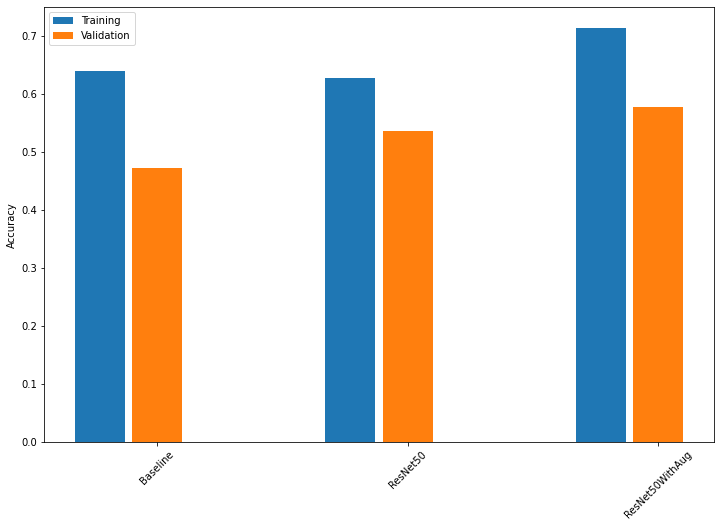

In [54]:
x = np.arange(len(train_performance))
width = 0.2

metric_name = 'accuracy'
metric_index = ResNet50.metrics_names.index('accuracy')
train_acc = [v[metric_index] for _, v in sorted(train_performance.items(), key = lambda x: x[0])]
val_acc = [v[metric_index] for _, v in sorted(val_performance.items(), key = lambda x: x[0])]
# test_acc = [v[metric_index] for v in performance.values()]
print(val_performance)
print(train_performance)
plt.figure(figsize=(12, 8))
plt.bar(x - 0.23, train_acc, width, label='Training')
plt.bar(x, val_acc, width, label='Validation')
#plt.bar(x + 0.23, test_acc, width, label='Test')
plt.xticks(ticks=x, labels=sorted(train_performance.keys()),
           rotation=45)
plt.ylabel('Accuracy')
_ = plt.legend()